# Исследование объявлений о продаже квартир

В вашем распоряжении данные сервиса Яндекс.Недвижимость — архив объявлений о продаже квартир в Санкт-Петербурге и соседних населённых пунктов за несколько лет. Нужно научиться определять рыночную стоимость объектов недвижимости. Ваша задача — установить параметры. Это позволит построить автоматизированную систему: она отследит аномалии и мошенническую деятельность. 

По каждой квартире на продажу доступны два вида данных. Первые вписаны пользователем, вторые — получены автоматически на основе картографических данных. Например, расстояние до центра, аэропорта, ближайшего парка и водоёма. 

### Шаг 1. Откройте файл с данными и изучите общую информацию. 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from pymystem3 import Mystem
from collections import Counter

df=pd.read_csv('/datasets/real_estate_data.csv', sep="\t")

In [2]:
display(df.head(10))

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
0,20,13000000.0,108.00,2019-03-07T00:00:00,3,2.70,16.0,51.00,8,NaN,...,25.00,NaN,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,NaN
1,7,3350000.0,40.40,2018-12-04T00:00:00,1,NaN,11.0,18.60,1,NaN,...,11.00,2.0,посёлок Шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81.0
2,10,5196000.0,56.00,2015-08-20T00:00:00,2,NaN,5.0,34.30,4,NaN,...,8.30,0.0,Санкт-Петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0
3,0,64900000.0,159.00,2015-07-24T00:00:00,3,NaN,14.0,NaN,9,NaN,...,NaN,0.0,Санкт-Петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424.0
4,2,10000000.0,100.00,2018-06-19T00:00:00,2,3.03,14.0,32.00,13,NaN,...,41.00,NaN,Санкт-Петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121.0
5,10,2890000.0,30.40,2018-09-10T00:00:00,1,NaN,12.0,14.40,5,NaN,...,9.10,NaN,городской посёлок Янино-1,NaN,NaN,NaN,NaN,NaN,NaN,55.0
6,6,3700000.0,37.30,2017-11-02T00:00:00,1,NaN,26.0,10.60,6,NaN,...,14.40,1.0,посёлок Парголово,52996.0,19143.0,0.0,NaN,0.0,NaN,155.0
7,5,7915000.0,71.60,2019-04-18T00:00:00,2,NaN,24.0,NaN,22,NaN,...,18.90,2.0,Санкт-Петербург,23982.0,11634.0,0.0,NaN,0.0,NaN,NaN
8,20,2900000.0,33.16,2018-05-23T00:00:00,1,NaN,27.0,15.43,26,NaN,...,8.81,NaN,посёлок Мурино,NaN,NaN,NaN,NaN,NaN,NaN,189.0
9,18,5400000.0,61.00,2017-02-26T00:00:00,3,2.50,9.0,43.60,7,NaN,...,6.50,2.0,Санкт-Петербург,50898.0,15008.0,0.0,NaN,0.0,NaN,289.0


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
total_images            23699 non-null int64
last_price              23699 non-null float64
total_area              23699 non-null float64
first_day_exposition    23699 non-null object
rooms                   23699 non-null int64
ceiling_height          14504 non-null float64
floors_total            23613 non-null float64
living_area             21796 non-null float64
floor                   23699 non-null int64
is_apartment            2775 non-null object
studio                  23699 non-null bool
open_plan               23699 non-null bool
kitchen_area            21421 non-null float64
balcony                 12180 non-null float64
locality_name           23650 non-null object
airports_nearest        18157 non-null float64
cityCenters_nearest     18180 non-null float64
parks_around3000        18181 non-null float64
parks_nearest           8079 non-null float64
ponds_around300

In [4]:
df.isnull().sum()

total_images                0
last_price                  0
total_area                  0
first_day_exposition        0
rooms                       0
ceiling_height           9195
floors_total               86
living_area              1903
floor                       0
is_apartment            20924
studio                      0
open_plan                   0
kitchen_area             2278
balcony                 11519
locality_name              49
airports_nearest         5542
cityCenters_nearest      5519
parks_around3000         5518
parks_nearest           15620
ponds_around3000         5518
ponds_nearest           14589
days_exposition          3181
dtype: int64

In [5]:
df['ceiling_height'].describe()

count    14504.000000
mean         2.771499
std          1.261056
min          1.000000
25%          2.520000
50%          2.650000
75%          2.800000
max        100.000000
Name: ceiling_height, dtype: float64

In [6]:
df['ceiling_height'].median()

2.65

In [7]:
df['ceiling_height'].fillna(df['ceiling_height'].mean(), inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
total_images            23699 non-null int64
last_price              23699 non-null float64
total_area              23699 non-null float64
first_day_exposition    23699 non-null object
rooms                   23699 non-null int64
ceiling_height          23699 non-null float64
floors_total            23613 non-null float64
living_area             21796 non-null float64
floor                   23699 non-null int64
is_apartment            2775 non-null object
studio                  23699 non-null bool
open_plan               23699 non-null bool
kitchen_area            21421 non-null float64
balcony                 12180 non-null float64
locality_name           23650 non-null object
airports_nearest        18157 non-null float64
cityCenters_nearest     18180 non-null float64
parks_around3000        18181 non-null float64
parks_nearest           8079 non-null float64
ponds_around300

Пропуски в высоте потолков заменил на среднее значение по столбцу, так как высота потолков во всех квартирах +/- одинаковая.
Отсутсвие данных значений указывает, что продавец мог просто не знать эту информацию

In [8]:
df['balcony'].fillna(0, inplace=True)
df['balcony'] = df['balcony'].astype('int64')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
total_images            23699 non-null int64
last_price              23699 non-null float64
total_area              23699 non-null float64
first_day_exposition    23699 non-null object
rooms                   23699 non-null int64
ceiling_height          23699 non-null float64
floors_total            23613 non-null float64
living_area             21796 non-null float64
floor                   23699 non-null int64
is_apartment            2775 non-null object
studio                  23699 non-null bool
open_plan               23699 non-null bool
kitchen_area            21421 non-null float64
balcony                 23699 non-null int64
locality_name           23650 non-null object
airports_nearest        18157 non-null float64
cityCenters_nearest     18180 non-null float64
parks_around3000        18181 non-null float64
parks_nearest           8079 non-null float64
ponds_around3000 

Пропусков в балконах очень много, но это, скорее всего, указывает, что балкона нет.

In [9]:
df['locality_name'].isna().sum()

49

Эти данные очень маленькие и не повлияют на итоговый расчёт. Тем более мы не можем определить, какой именно город или посёлок,
А это значит, что и расстояние до разных мест не определить.

In [10]:
df = df.dropna(subset=['locality_name'])
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23650 entries, 0 to 23698
Data columns (total 22 columns):
total_images            23650 non-null int64
last_price              23650 non-null float64
total_area              23650 non-null float64
first_day_exposition    23650 non-null object
rooms                   23650 non-null int64
ceiling_height          23650 non-null float64
floors_total            23565 non-null float64
living_area             21752 non-null float64
floor                   23650 non-null int64
is_apartment            2760 non-null object
studio                  23650 non-null bool
open_plan               23650 non-null bool
kitchen_area            21381 non-null float64
balcony                 23650 non-null int64
locality_name           23650 non-null object
airports_nearest        18116 non-null float64
cityCenters_nearest     18139 non-null float64
parks_around3000        18140 non-null float64
parks_nearest           8064 non-null float64
ponds_around3000 

In [11]:
df['floors_total'].isnull().sum()

85

In [12]:
df = df.dropna(subset=['floors_total'])
df['floors_total'] = df['floors_total'].astype('int64')
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23565 entries, 0 to 23698
Data columns (total 22 columns):
total_images            23565 non-null int64
last_price              23565 non-null float64
total_area              23565 non-null float64
first_day_exposition    23565 non-null object
rooms                   23565 non-null int64
ceiling_height          23565 non-null float64
floors_total            23565 non-null int64
living_area             21700 non-null float64
floor                   23565 non-null int64
is_apartment            2760 non-null object
studio                  23565 non-null bool
open_plan               23565 non-null bool
kitchen_area            21343 non-null float64
balcony                 23565 non-null int64
locality_name           23565 non-null object
airports_nearest        18041 non-null float64
cityCenters_nearest     18064 non-null float64
parks_around3000        18065 non-null float64
parks_nearest           8030 non-null float64
ponds_around3000   

Пропущенные значения в столбце общего количества этажей могут указывать, что это простой дом в поселке.
Для пропущенных значений подставлю 1

In [13]:
df['airports_nearest'] = df['airports_nearest'] / 1000
df['cityCenters_nearest'] = df['cityCenters_nearest'] / 1000

Значения в расстояниях до аэропорта и до центра города разделю на 1000, чтобы они были показаны в километрах, что удобнее

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23565 entries, 0 to 23698
Data columns (total 22 columns):
total_images            23565 non-null int64
last_price              23565 non-null float64
total_area              23565 non-null float64
first_day_exposition    23565 non-null object
rooms                   23565 non-null int64
ceiling_height          23565 non-null float64
floors_total            23565 non-null int64
living_area             21700 non-null float64
floor                   23565 non-null int64
is_apartment            2760 non-null object
studio                  23565 non-null bool
open_plan               23565 non-null bool
kitchen_area            21343 non-null float64
balcony                 23565 non-null int64
locality_name           23565 non-null object
airports_nearest        18041 non-null float64
cityCenters_nearest     18064 non-null float64
parks_around3000        18065 non-null float64
parks_nearest           8030 non-null float64
ponds_around3000   

In [15]:
df['parks_around3000'].fillna(1, inplace=True)
df['ponds_around3000'].fillna(0, inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23565 entries, 0 to 23698
Data columns (total 22 columns):
total_images            23565 non-null int64
last_price              23565 non-null float64
total_area              23565 non-null float64
first_day_exposition    23565 non-null object
rooms                   23565 non-null int64
ceiling_height          23565 non-null float64
floors_total            23565 non-null int64
living_area             21700 non-null float64
floor                   23565 non-null int64
is_apartment            2760 non-null object
studio                  23565 non-null bool
open_plan               23565 non-null bool
kitchen_area            21343 non-null float64
balcony                 23565 non-null int64
locality_name           23565 non-null object
airports_nearest        18041 non-null float64
cityCenters_nearest     18064 non-null float64
parks_around3000        23565 non-null float64
parks_nearest           8030 non-null float64
ponds_around3000   

Заменил значения парках и прудах на расстоянии 3000 метров на 1 и 0 соответственно, так как:
Чтобы не было ни одного парка в округе 3 км - уникальный случай, а если это дом за городом, то участок и лес и есть парки
Незаполненные значения в наличии пруда - скорее всего, они там отсутсвуют, значит, 0

In [16]:
df['locality_name'].unique().tolist()

['Санкт-Петербург',
 'посёлок Шушары',
 'городской посёлок Янино-1',
 'посёлок Парголово',
 'посёлок Мурино',
 'Ломоносов',
 'Сертолово',
 'Петергоф',
 'Пушкин',
 'деревня Кудрово',
 'Коммунар',
 'Колпино',
 'поселок городского типа Красный Бор',
 'Гатчина',
 'поселок Мурино',
 'деревня Фёдоровское',
 'Выборг',
 'Кронштадт',
 'Кировск',
 'деревня Новое Девяткино',
 'посёлок Металлострой',
 'посёлок городского типа Лебяжье',
 'посёлок городского типа Сиверский',
 'поселок Молодцово',
 'поселок городского типа Кузьмоловский',
 'садовое товарищество Новая Ропша',
 'Павловск',
 'деревня Пикколово',
 'Всеволожск',
 'Волхов',
 'Кингисепп',
 'Приозерск',
 'Сестрорецк',
 'деревня Куттузи',
 'посёлок Аннино',
 'поселок городского типа Ефимовский',
 'посёлок Плодовое',
 'деревня Заклинье',
 'поселок Торковичи',
 'поселок Первомайское',
 'Красное Село',
 'посёлок Понтонный',
 'Сясьстрой',
 'деревня Старая',
 'деревня Лесколово',
 'посёлок Новый Свет',
 'Сланцы',
 'село Путилово',
 'Ивангород',
 '

In [17]:
len(df['locality_name'].unique())

364

Налицо присутствие названий с е и ё. Заменю их

In [18]:
df['locality_name'] = df['locality_name'].str.replace('ё', 'е', regex=True)

In [19]:
len(df['locality_name'].unique())

330

In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23565 entries, 0 to 23698
Data columns (total 22 columns):
total_images            23565 non-null int64
last_price              23565 non-null float64
total_area              23565 non-null float64
first_day_exposition    23565 non-null object
rooms                   23565 non-null int64
ceiling_height          23565 non-null float64
floors_total            23565 non-null int64
living_area             21700 non-null float64
floor                   23565 non-null int64
is_apartment            2760 non-null object
studio                  23565 non-null bool
open_plan               23565 non-null bool
kitchen_area            21343 non-null float64
balcony                 23565 non-null int64
locality_name           23565 non-null object
airports_nearest        18041 non-null float64
cityCenters_nearest     18064 non-null float64
parks_around3000        23565 non-null float64
parks_nearest           8030 non-null float64
ponds_around3000   

In [21]:
df.duplicated().sum()

0

### Вывод

Общее количество наблюдений - 23650

Дубликатов нет, что позволяет работать с данными

Многие пропуски были удалены или исправлены

Теперь я предобработаю некоторые сомнительные данные и буду проводить анализ.

### Шаг 2. Предобработка данных

In [22]:
df['first_day_exposition'] = pd.to_datetime(df['first_day_exposition'], format="%Y-%m-%dT%H:%M:%S")

Колонку с первым днем объявления привели к читаемому виду 

In [23]:
df.head(10)

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
0,20,13000000.0,108.00,2019-03-07,3,2.700000,16,51.00,8,NaN,...,25.00,0,Санкт-Петербург,18.863,16.028,1.0,482.0,2.0,755.0,NaN
1,7,3350000.0,40.40,2018-12-04,1,2.771499,11,18.60,1,NaN,...,11.00,2,поселок Шушары,12.817,18.603,0.0,NaN,0.0,NaN,81.0
2,10,5196000.0,56.00,2015-08-20,2,2.771499,5,34.30,4,NaN,...,8.30,0,Санкт-Петербург,21.741,13.933,1.0,90.0,2.0,574.0,558.0
3,0,64900000.0,159.00,2015-07-24,3,2.771499,14,NaN,9,NaN,...,NaN,0,Санкт-Петербург,28.098,6.800,2.0,84.0,3.0,234.0,424.0
4,2,10000000.0,100.00,2018-06-19,2,3.030000,14,32.00,13,NaN,...,41.00,0,Санкт-Петербург,31.856,8.098,2.0,112.0,1.0,48.0,121.0
5,10,2890000.0,30.40,2018-09-10,1,2.771499,12,14.40,5,NaN,...,9.10,0,городской поселок Янино-1,NaN,NaN,1.0,NaN,0.0,NaN,55.0
6,6,3700000.0,37.30,2017-11-02,1,2.771499,26,10.60,6,NaN,...,14.40,1,поселок Парголово,52.996,19.143,0.0,NaN,0.0,NaN,155.0
7,5,7915000.0,71.60,2019-04-18,2,2.771499,24,NaN,22,NaN,...,18.90,2,Санкт-Петербург,23.982,11.634,0.0,NaN,0.0,NaN,NaN
8,20,2900000.0,33.16,2018-05-23,1,2.771499,27,15.43,26,NaN,...,8.81,0,поселок Мурино,NaN,NaN,1.0,NaN,0.0,NaN,189.0
9,18,5400000.0,61.00,2017-02-26,3,2.500000,9,43.60,7,NaN,...,6.50,2,Санкт-Петербург,50.898,15.008,0.0,NaN,0.0,NaN,289.0


In [24]:
df.describe()

,total_images,last_price,total_area,rooms,ceiling_height,floors_total,living_area,floor,kitchen_area,balcony,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
count,23565.000000,2.356500e+04,23565.000000,23565.000000,23565.000000,23565.000000,21700.000000,23565.000000,21343.000000,23565.000000,18041.000000,18064.000000,23565.000000,8030.000000,23565.000000,9036.000000,20394.000000
mean,9.878421,6.540058e+06,60.322824,2.070656,2.771366,10.675875,34.454822,5.878124,10.560994,0.593677,28.797083,14.192656,0.702228,490.580448,0.589900,518.289509,180.741395
std,5.681156,1.091093e+07,35.657060,1.078591,0.989266,6.594823,22.045359,4.871485,5.900630,0.960660,12.632500,8.613348,0.721235,341.572956,0.883966,278.009558,219.732782
min,0.000000,1.219000e+04,12.000000,0.000000,1.000000,1.000000,2.000000,1.000000,1.300000,0.000000,0.000000,0.181000,0.000000,1.000000,0.000000,13.000000,1.000000
25%,6.000000,3.400000e+06,40.000000,1.000000,2.600000,5.000000,18.600000,2.000000,7.000000,0.000000,18.565000,9.238000,0.000000,288.000000,0.000000,293.000000,45.000000
50%,9.000000,4.646000e+06,52.000000,2.000000,2.771499,9.000000,30.000000,4.000000,9.100000,0.000000,26.757000,13.096500,1.000000,455.000000,0.000000,503.000000,95.000000
75%,14.000000,6.790000e+06,69.700000,3.000000,2.771499,16.000000,42.300000,8.000000,12.000000,1.000000,37.273000,16.285000,1.000000,612.000000,1.000000,730.000000,231.000000
max,50.000000,7.630000e+08,900.000000,19.000000,100.000000,60.000000,409.700000,33.000000,112.000000,5.000000,84.869000,65.968000,3.000000,3190.000000,3.000000,1344.000000,1580.000000


Настало время разобраться с пропусками в is_appartment
Согласно данным, которые я смог изучить, апартаменты - нежилое помещение, которое может использоваться для жилья.
Но по документам они числятся нежилым помещением.
В связи с полученной информацией заменю значения на False, так как пропуски скорее всего означают, что люди уверены, что у них
не апартаменты. Поэтому не стали заполнять.
Да и сами апартаменты - редкость.

In [25]:
df['is_apartment'] = df['is_apartment'].fillna(False)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23565 entries, 0 to 23698
Data columns (total 22 columns):
total_images            23565 non-null int64
last_price              23565 non-null float64
total_area              23565 non-null float64
first_day_exposition    23565 non-null datetime64[ns]
rooms                   23565 non-null int64
ceiling_height          23565 non-null float64
floors_total            23565 non-null int64
living_area             21700 non-null float64
floor                   23565 non-null int64
is_apartment            23565 non-null bool
studio                  23565 non-null bool
open_plan               23565 non-null bool
kitchen_area            21343 non-null float64
balcony                 23565 non-null int64
locality_name           23565 non-null object
airports_nearest        18041 non-null float64
cityCenters_nearest     18064 non-null float64
parks_around3000        23565 non-null float64
parks_nearest           8030 non-null float64
ponds_around

Оптимально, все данные обработаны.
Теперь добавлю необходимые колонки

### Шаг 3. Посчитайте и добавьте в таблицу

In [26]:
#добавлю колонку с ценой за квадратный метр
df['price_per_meter'] = df['last_price'] / df['total_area']
df['price_per_meter'] = df['price_per_meter'].round(1)
df.head(10)

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,price_per_meter
0,20,13000000.0,108.00,2019-03-07,3,2.700000,16,51.00,8,False,...,0,Санкт-Петербург,18.863,16.028,1.0,482.0,2.0,755.0,NaN,120370.4
1,7,3350000.0,40.40,2018-12-04,1,2.771499,11,18.60,1,False,...,2,поселок Шушары,12.817,18.603,0.0,NaN,0.0,NaN,81.0,82920.8
2,10,5196000.0,56.00,2015-08-20,2,2.771499,5,34.30,4,False,...,0,Санкт-Петербург,21.741,13.933,1.0,90.0,2.0,574.0,558.0,92785.7
3,0,64900000.0,159.00,2015-07-24,3,2.771499,14,NaN,9,False,...,0,Санкт-Петербург,28.098,6.800,2.0,84.0,3.0,234.0,424.0,408176.1
4,2,10000000.0,100.00,2018-06-19,2,3.030000,14,32.00,13,False,...,0,Санкт-Петербург,31.856,8.098,2.0,112.0,1.0,48.0,121.0,100000.0
5,10,2890000.0,30.40,2018-09-10,1,2.771499,12,14.40,5,False,...,0,городской поселок Янино-1,NaN,NaN,1.0,NaN,0.0,NaN,55.0,95065.8
6,6,3700000.0,37.30,2017-11-02,1,2.771499,26,10.60,6,False,...,1,поселок Парголово,52.996,19.143,0.0,NaN,0.0,NaN,155.0,99195.7
7,5,7915000.0,71.60,2019-04-18,2,2.771499,24,NaN,22,False,...,2,Санкт-Петербург,23.982,11.634,0.0,NaN,0.0,NaN,NaN,110544.7
8,20,2900000.0,33.16,2018-05-23,1,2.771499,27,15.43,26,False,...,0,поселок Мурино,NaN,NaN,1.0,NaN,0.0,NaN,189.0,87454.8
9,18,5400000.0,61.00,2017-02-26,3,2.500000,9,43.60,7,False,...,2,Санкт-Петербург,50.898,15.008,0.0,NaN,0.0,NaN,289.0,88524.6


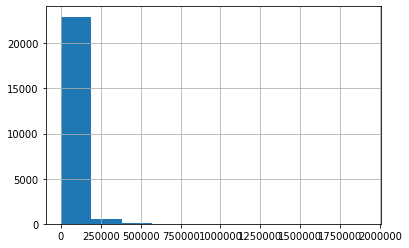

In [27]:
df['price_per_meter'].hist()

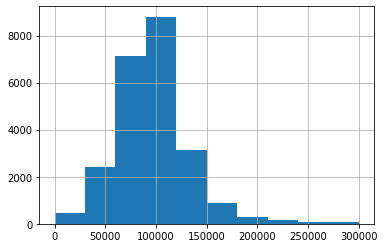

In [28]:
df['price_per_meter'].hist(range=(0, 300000))

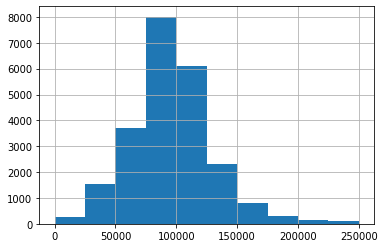

In [29]:
df['price_per_meter'].hist(range=(0, 250000))

In [30]:
df['days_exposition'] = df['days_exposition'].fillna(0).astype('int')
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23565 entries, 0 to 23698
Data columns (total 23 columns):
total_images            23565 non-null int64
last_price              23565 non-null float64
total_area              23565 non-null float64
first_day_exposition    23565 non-null datetime64[ns]
rooms                   23565 non-null int64
ceiling_height          23565 non-null float64
floors_total            23565 non-null int64
living_area             21700 non-null float64
floor                   23565 non-null int64
is_apartment            23565 non-null bool
studio                  23565 non-null bool
open_plan               23565 non-null bool
kitchen_area            21343 non-null float64
balcony                 23565 non-null int64
locality_name           23565 non-null object
airports_nearest        18041 non-null float64
cityCenters_nearest     18064 non-null float64
parks_around3000        23565 non-null float64
parks_nearest           8030 non-null float64
ponds_around

In [31]:
#добавлю колонки с днем, месяцем, годов объявления
df['day_exposition'] = df['first_day_exposition'].dt.day_name()
df['month_exposition'] = df['first_day_exposition'].dt.month_name()
df['year_exposition'] = df['first_day_exposition'].dt.year
df.head(10)

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,price_per_meter,day_exposition,month_exposition,year_exposition
0,20,13000000.0,108.00,2019-03-07,3,2.700000,16,51.00,8,False,...,16.028,1.0,482.0,2.0,755.0,0,120370.4,Thursday,March,2019
1,7,3350000.0,40.40,2018-12-04,1,2.771499,11,18.60,1,False,...,18.603,0.0,NaN,0.0,NaN,81,82920.8,Tuesday,December,2018
2,10,5196000.0,56.00,2015-08-20,2,2.771499,5,34.30,4,False,...,13.933,1.0,90.0,2.0,574.0,558,92785.7,Thursday,August,2015
3,0,64900000.0,159.00,2015-07-24,3,2.771499,14,NaN,9,False,...,6.800,2.0,84.0,3.0,234.0,424,408176.1,Friday,July,2015
4,2,10000000.0,100.00,2018-06-19,2,3.030000,14,32.00,13,False,...,8.098,2.0,112.0,1.0,48.0,121,100000.0,Tuesday,June,2018
5,10,2890000.0,30.40,2018-09-10,1,2.771499,12,14.40,5,False,...,NaN,1.0,NaN,0.0,NaN,55,95065.8,Monday,September,2018
6,6,3700000.0,37.30,2017-11-02,1,2.771499,26,10.60,6,False,...,19.143,0.0,NaN,0.0,NaN,155,99195.7,Thursday,November,2017
7,5,7915000.0,71.60,2019-04-18,2,2.771499,24,NaN,22,False,...,11.634,0.0,NaN,0.0,NaN,0,110544.7,Thursday,April,2019
8,20,2900000.0,33.16,2018-05-23,1,2.771499,27,15.43,26,False,...,NaN,1.0,NaN,0.0,NaN,189,87454.8,Wednesday,May,2018
9,18,5400000.0,61.00,2017-02-26,3,2.500000,9,43.60,7,False,...,15.008,0.0,NaN,0.0,NaN,289,88524.6,Sunday,February,2017


In [32]:
#Создам функцию и добавлю варианты этажей
def type_floor(row):
    if row['floor'] == 1:
        return 'первый'
    if row['floor'] == row['floors_total']:
        return 'последний'
    else:
        return 'другой'
df['type_floor'] = df.apply(type_floor, axis=1)
df.head(10)

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,price_per_meter,day_exposition,month_exposition,year_exposition,type_floor
0,20,13000000.0,108.00,2019-03-07,3,2.700000,16,51.00,8,False,...,1.0,482.0,2.0,755.0,0,120370.4,Thursday,March,2019,другой
1,7,3350000.0,40.40,2018-12-04,1,2.771499,11,18.60,1,False,...,0.0,NaN,0.0,NaN,81,82920.8,Tuesday,December,2018,первый
2,10,5196000.0,56.00,2015-08-20,2,2.771499,5,34.30,4,False,...,1.0,90.0,2.0,574.0,558,92785.7,Thursday,August,2015,другой
3,0,64900000.0,159.00,2015-07-24,3,2.771499,14,NaN,9,False,...,2.0,84.0,3.0,234.0,424,408176.1,Friday,July,2015,другой
4,2,10000000.0,100.00,2018-06-19,2,3.030000,14,32.00,13,False,...,2.0,112.0,1.0,48.0,121,100000.0,Tuesday,June,2018,другой
5,10,2890000.0,30.40,2018-09-10,1,2.771499,12,14.40,5,False,...,1.0,NaN,0.0,NaN,55,95065.8,Monday,September,2018,другой
6,6,3700000.0,37.30,2017-11-02,1,2.771499,26,10.60,6,False,...,0.0,NaN,0.0,NaN,155,99195.7,Thursday,November,2017,другой
7,5,7915000.0,71.60,2019-04-18,2,2.771499,24,NaN,22,False,...,0.0,NaN,0.0,NaN,0,110544.7,Thursday,April,2019,другой
8,20,2900000.0,33.16,2018-05-23,1,2.771499,27,15.43,26,False,...,1.0,NaN,0.0,NaN,189,87454.8,Wednesday,May,2018,другой
9,18,5400000.0,61.00,2017-02-26,3,2.500000,9,43.60,7,False,...,0.0,NaN,0.0,NaN,289,88524.6,Sunday,February,2017,другой


Добавлю соотношения жилой и общей площади, отношение площади кухни к общей площади

In [33]:
df['area_ratio'] = df['living_area'] / df['total_area']
df['kitchen_area_ratio'] = df['kitchen_area'] / df['total_area']
df['area_ratio'] = df['area_ratio'].round(2)
df['kitchen_area_ratio'] = df['kitchen_area_ratio'].round(2)
df.head(10)

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,ponds_around3000,ponds_nearest,days_exposition,price_per_meter,day_exposition,month_exposition,year_exposition,type_floor,area_ratio,kitchen_area_ratio
0,20,13000000.0,108.00,2019-03-07,3,2.700000,16,51.00,8,False,...,2.0,755.0,0,120370.4,Thursday,March,2019,другой,0.47,0.23
1,7,3350000.0,40.40,2018-12-04,1,2.771499,11,18.60,1,False,...,0.0,NaN,81,82920.8,Tuesday,December,2018,первый,0.46,0.27
2,10,5196000.0,56.00,2015-08-20,2,2.771499,5,34.30,4,False,...,2.0,574.0,558,92785.7,Thursday,August,2015,другой,0.61,0.15
3,0,64900000.0,159.00,2015-07-24,3,2.771499,14,NaN,9,False,...,3.0,234.0,424,408176.1,Friday,July,2015,другой,NaN,NaN
4,2,10000000.0,100.00,2018-06-19,2,3.030000,14,32.00,13,False,...,1.0,48.0,121,100000.0,Tuesday,June,2018,другой,0.32,0.41
5,10,2890000.0,30.40,2018-09-10,1,2.771499,12,14.40,5,False,...,0.0,NaN,55,95065.8,Monday,September,2018,другой,0.47,0.30
6,6,3700000.0,37.30,2017-11-02,1,2.771499,26,10.60,6,False,...,0.0,NaN,155,99195.7,Thursday,November,2017,другой,0.28,0.39
7,5,7915000.0,71.60,2019-04-18,2,2.771499,24,NaN,22,False,...,0.0,NaN,0,110544.7,Thursday,April,2019,другой,NaN,0.26
8,20,2900000.0,33.16,2018-05-23,1,2.771499,27,15.43,26,False,...,0.0,NaN,189,87454.8,Wednesday,May,2018,другой,0.47,0.27
9,18,5400000.0,61.00,2017-02-26,3,2.500000,9,43.60,7,False,...,0.0,NaN,289,88524.6,Sunday,February,2017,другой,0.71,0.11


Требуемые колонки добавлены, расчеты произведены. 
Перехожу к анализу данных

### Шаг 4. Проведите исследовательский анализ данных и выполните инструкции:

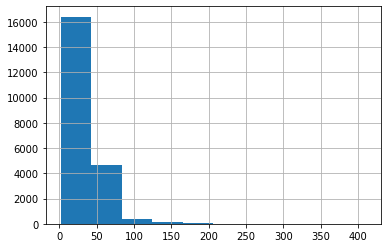

In [34]:
df['living_area'].hist()

Больше всего жилых помещений (свыше 16.000) с площадью до 50 кв.м., следом идет до 80 кв.м 
Рассмотрим гистограмму со значением до 100 кв.м

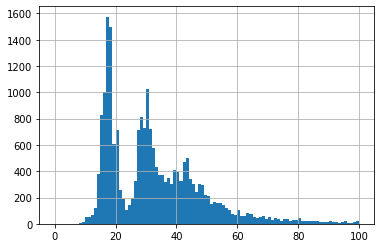

In [35]:
df['living_area'].hist(bins=100, range=(0, 100))

Теперь мы видим пиковые значения количества объявлений, а именно 18-19 кв.м, 25 кв.м, 42 кв.м.

<div class="alert alert-warning">
<h2>Комментарий ревьюера</h2>
    
Чем могли бы быть вызваны такие пики? Как их можно объяснить?</div>

<div class="alert alert-block alert-info">
Такие данные могут говорить о том, какие объявления наиболее популярны. По типу квартир. Что объявления о продаже маленьких площадей популярны, ходовые и таких квартир большинство. Активность по ним высокая   
</div>

In [36]:
df['last_price'].describe().apply('{0:.5f}'.format)

count        23565.00000
mean       6540058.26000
std       10910934.72151
min          12190.00000
25%        3400000.00000
50%        4646000.00000
75%        6790000.00000
max      763000000.00000
Name: last_price, dtype: object

(0, 763000000)

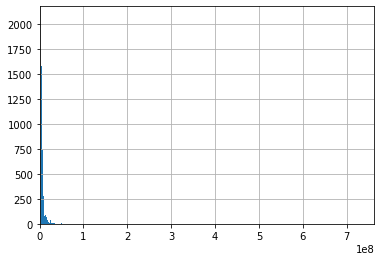

In [37]:
df['last_price'].hist(bins = 2000)
plt.xlim(0,763000000)

График не совсем понятный, но очевидно, что огромная цена - это выброс. Попробуем установить меньший лимит

(0, 10000000)

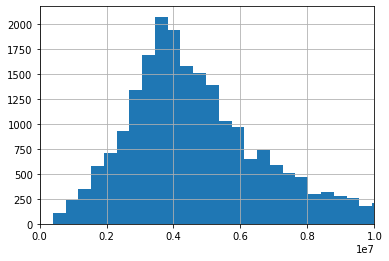

In [38]:
df['last_price'].hist(bins = 2000)
plt.xlim(0,10000000)

Теперь гистограмма читаема. Мы видим, что пиковое значение стоимости квартир приходится на сумму около 4.000.000, 
После этого идет резкий спад.
Ориентируясь на предыдущий график с площадью, можно сделать вывод, что больше всего объявлений на небольшие квартиры

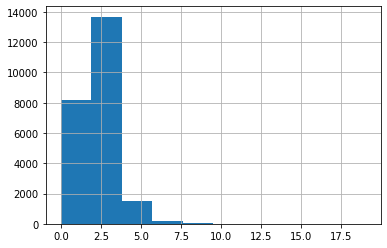

In [39]:
df['rooms'].hist()

Наибольшее количество квартир у нас в диапазоне от 0 до 5, остальное - выброс. Рассмотрим более детально

(0, 5)

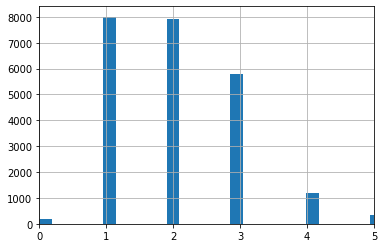

In [40]:
df['rooms'].hist(bins=100)
plt.xlim(0,5)

Так как значения комнат у нас только целые числа, то мы видим гистограмму, где пиковые значения - 1, 2 и 3 комнаты

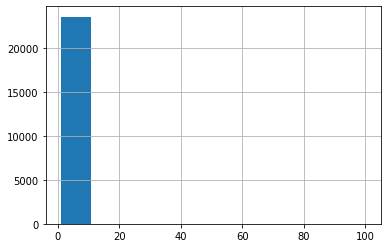

In [41]:
df['ceiling_height'].hist()

Высота потолков тоже не читаема. Уменьшим диапазон

(0, 5)

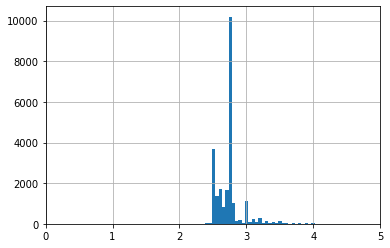

In [42]:
df['ceiling_height'].hist(bins=2000)
plt.xlim(0,5)

Теперь мы видим, что больше всего объявлений, где высота потолков у нас около 3м

Приступим к изучение данных по времени продажи квартиры.
Чуть выше методом describe я получл, что среднее время объявлений - 180 дней, минимально - 1 день, максимум 1580.
Теперь посмотрю все эти данные на графике

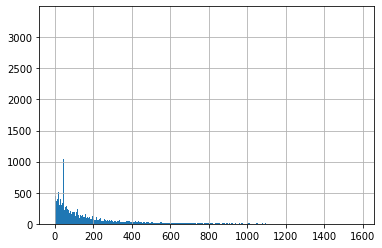

In [43]:
df['days_exposition'].hist(bins=500)

при построении обычной гистограммы мы получаем не совсем читаемый результат. Но уже видно, что есть пиковые значения.
рассмотрим эти данные, но уже более детально, применим метод plot
Ограничения возьмем с 1 (минимальное) до 1600, так как на нашей гистограмме это предельное значение

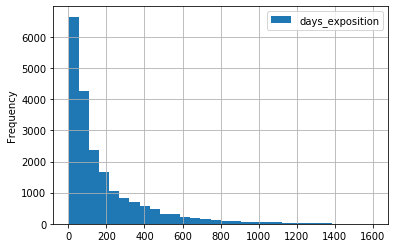

In [44]:
df.plot(y = 'days_exposition', kind = 'hist', bins = 30, grid = True, range = (1,1600))

Налицо распределение Пуасона. Но данные все равно не подходят.
Попробуем еще уменьшить диапазон, так как около 600 уже совсем мало значений

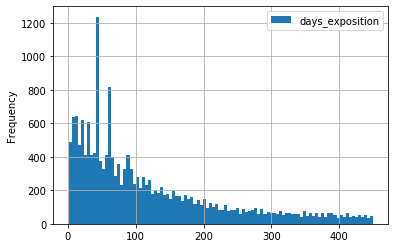

In [45]:
df.plot(y = 'days_exposition', kind = 'hist', bins = 100, grid = True, range = (1,450))

Уже выглядит лучше. Особенно выбиваются некоторые значения, которые необходимо изучить детально. Возьмем ограничение до 200

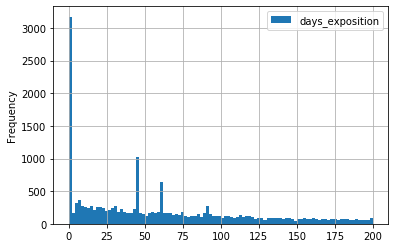

In [46]:
df.plot(y = 'days_exposition', kind = 'hist', bins = 100, grid = True, range = (0,200))

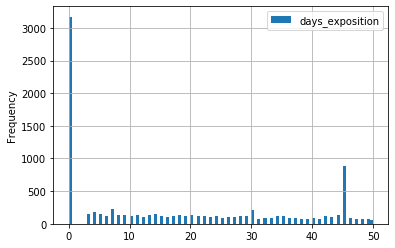

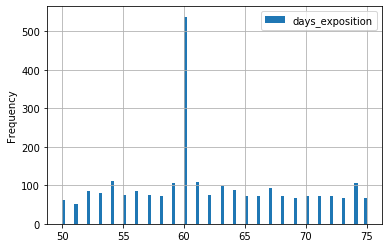

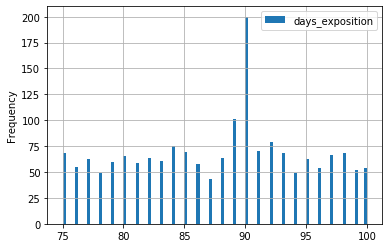

In [47]:
df.plot(y = 'days_exposition', kind = 'hist', bins = 100, grid = True, range = (0,50))
df.plot(y = 'days_exposition', kind = 'hist', bins = 100, grid = True, range = (50,75))
df.plot(y = 'days_exposition', kind = 'hist', bins = 100, grid = True, range = (75,100))

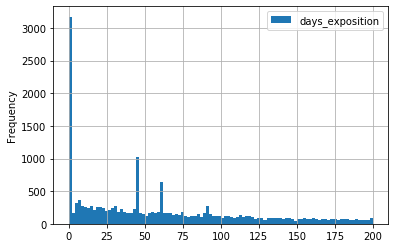

In [48]:
#day_list = [45, 60, 90]
#df.query('days_exposition != @day_list')['days_exposition'].value_counts()
#df['days_exposition'] = df.loc[df['days_exposition'] != 45, 'days_exposition']
#df['days_exposition'] = df.loc[df['days_exposition'] != 60, 'days_exposition']
#df['days_exposition'] = df.loc[df['days_exposition'] != 90, 'days_exposition']
df.plot(y='days_exposition', kind='hist', bins=100, grid=True, range=(0,200))

Построю дополнительно диаграмму размаха, чтобы посмотреть выбросы 

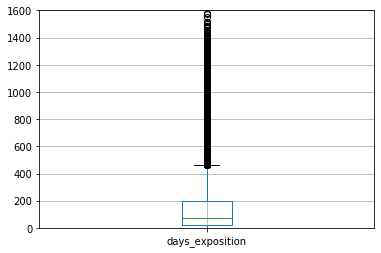

In [49]:
plt.ylim(0,1600)
df.boxplot(column = 'days_exposition')

Здесь мы наблюдаем пиковые аномалии, расположенные на 45, 60 и 90 днях.
Изучив инструкцию по размещению объявлений на Яндексе (https://yandex.ru/support/realty/owner/home/add-ads-housing.html) 
обратил внимание на таблицу, где описано, что данные автоматически удаляются на 45, 60 и 90 днях. 
Это означает, что эти данные о снятии с продажи. Либо человек уже продал квартиру, но забыл снять объявление 
С помощью диаграммы размаха получил результат, что нормальные значения располагаются от 1 до 500 дней. 

In [50]:
df['days_exposition'].median()

73.0

Перейду к обработке данных
Посмотрю гистограммы по данным, которые до этого не брал в расчет

In [51]:
df['balcony'].describe()

count    23565.000000
mean         0.593677
std          0.960660
min          0.000000
25%          0.000000
50%          0.000000
75%          1.000000
max          5.000000
Name: balcony, dtype: float64

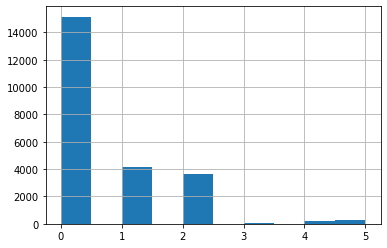

In [52]:
df['balcony'].hist()

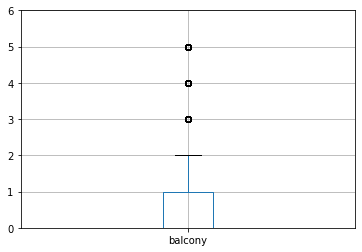

In [53]:
plt.ylim(0,6)
df.boxplot(column = 'balcony')

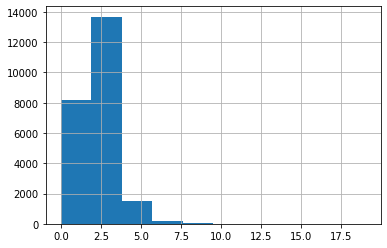

In [54]:
df['rooms'].hist()

In [55]:
df['rooms'].describe()

count    23565.000000
mean         2.070656
std          1.078591
min          0.000000
25%          1.000000
50%          2.000000
75%          3.000000
max         19.000000
Name: rooms, dtype: float64

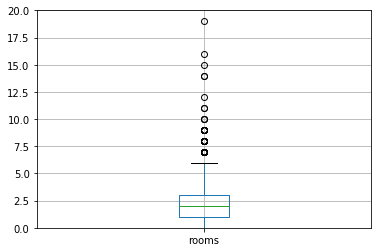

In [56]:
plt.ylim(0,20)
df.boxplot(column = 'rooms')

In [57]:
df[df['rooms'] > 6].count()

total_images            90
last_price              90
total_area              90
first_day_exposition    90
rooms                   90
ceiling_height          90
floors_total            90
living_area             83
floor                   90
is_apartment            90
studio                  90
open_plan               90
kitchen_area            79
balcony                 90
locality_name           90
airports_nearest        87
cityCenters_nearest     88
parks_around3000        90
parks_nearest           64
ponds_around3000        90
ponds_nearest           55
days_exposition         90
price_per_meter         90
day_exposition          90
month_exposition        90
year_exposition         90
type_floor              90
area_ratio              83
kitchen_area_ratio      79
dtype: int64

In [58]:
clean_df = df.query('rooms < 8')

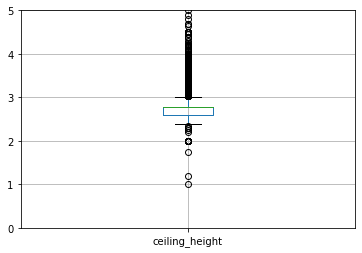

In [59]:
plt.ylim(0,5)
df.boxplot(column = 'ceiling_height')

In [60]:
clean_df = df.query('ceiling_height < 4.5')

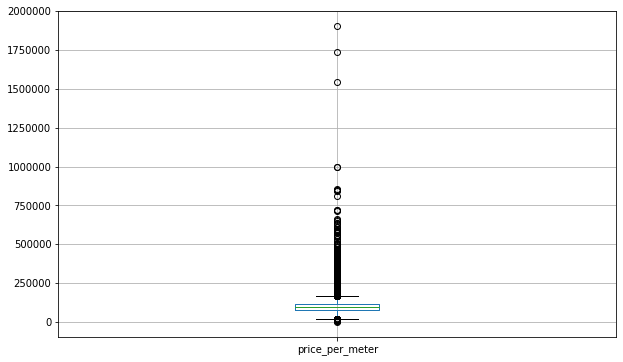

In [61]:
df.boxplot(column = 'price_per_meter', figsize=(10,6))

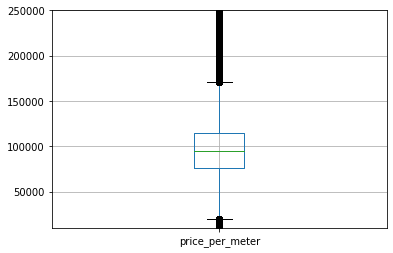

In [62]:
plt.ylim(10000,250000)
df.boxplot(column = 'price_per_meter', figsize=(10,2))

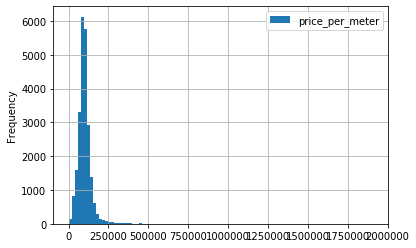

In [63]:
df.plot(y = 'price_per_meter', kind = 'hist', bins = 100, grid = True)

По балконам и комнатам есть странные данные (5 балконов?) но они не критичны, их можно оставить
Создам новую базу данных, куда запишу определенные условия (ограничения):
Жилая площадь менее 200 кв м (на графике выше было видно, что после 200 кв м данных практически нет)

In [64]:
clean_df = df.query('living_area < 200 and 10000 < price_per_meter < 250000 and rooms != 0')
clean_df.describe()

,total_images,last_price,total_area,rooms,ceiling_height,floors_total,living_area,floor,kitchen_area,balcony,...,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,price_per_meter,year_exposition,area_ratio,kitchen_area_ratio
count,21248.000000,2.124800e+04,21248.000000,21248.000000,21248.000000,21248.000000,21248.000000,21248.000000,20645.000000,21248.000000,...,16446.000000,21248.000000,7236.000000,21248.000000,8085.000000,21248.000000,21248.000000,21248.000000,21248.000000,20645.000000
mean,10.015625,5.836012e+06,58.946276,2.069983,2.762254,10.630271,33.796823,5.864458,10.310459,0.614411,...,14.387110,0.689477,490.506910,0.578502,522.936302,159.040239,96129.584046,2017.355328,0.563962,0.186989
std,5.654661,4.464250e+06,29.731731,1.034514,0.777098,6.557591,19.301601,4.848685,5.203002,0.966465,...,8.667976,0.715104,339.418934,0.870682,277.844904,214.323334,33138.885015,1.044888,0.104264,0.072119
min,0.000000,4.300000e+05,12.000000,1.000000,1.000000,1.000000,2.000000,1.000000,1.300000,0.000000,...,0.181000,0.000000,1.000000,0.000000,13.000000,0.000000,10185.200000,2014.000000,0.040000,0.030000
25%,6.000000,3.450000e+06,40.000000,1.000000,2.600000,5.000000,18.600000,2.000000,7.000000,0.000000,...,9.594000,0.000000,289.000000,0.000000,302.000000,22.000000,76751.850000,2017.000000,0.490000,0.130000
50%,10.000000,4.640000e+06,52.000000,2.000000,2.771499,9.000000,30.000000,4.000000,9.000000,0.000000,...,13.188000,1.000000,455.000000,0.000000,507.000000,78.000000,94666.700000,2017.000000,0.570000,0.170000
75%,14.000000,6.680000e+06,68.800000,3.000000,2.771499,16.000000,42.000000,8.000000,11.800000,1.000000,...,16.317750,1.000000,611.000000,1.000000,734.000000,204.000000,112941.200000,2018.000000,0.640000,0.230000
max,50.000000,7.390000e+07,413.500000,16.000000,32.000000,60.000000,199.000000,33.000000,100.700000,5.000000,...,65.968000,3.000000,3190.000000,3.000000,1344.000000,1580.000000,249375.000000,2019.000000,0.980000,0.790000


Перейду к изучению факторов, которые влияют на стоимость квартиры
Так как по условию нам известны факторы, которые необходимо проверить, создам из них список.

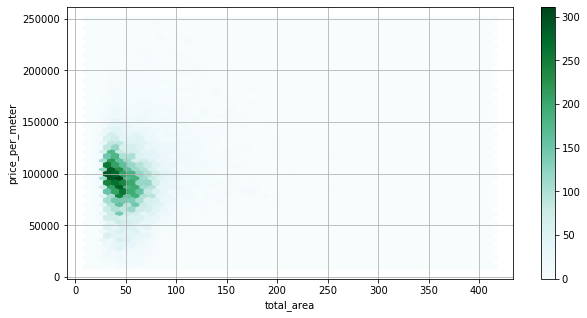

Коэффицент корреляции price_per_meter и total_area :0.17


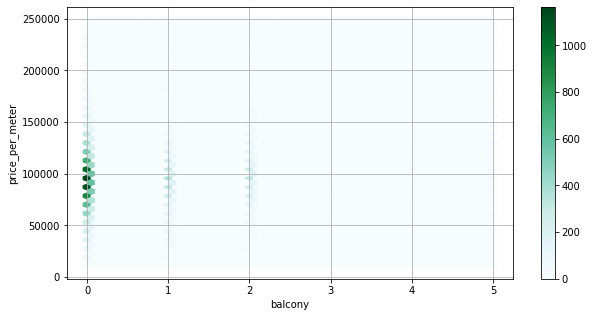

Коэффицент корреляции price_per_meter и balcony :0.03


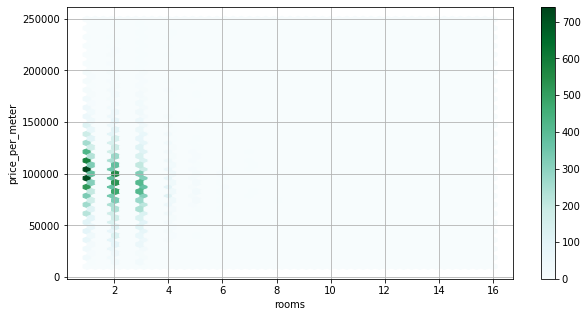

Коэффицент корреляции price_per_meter и rooms :-0.04


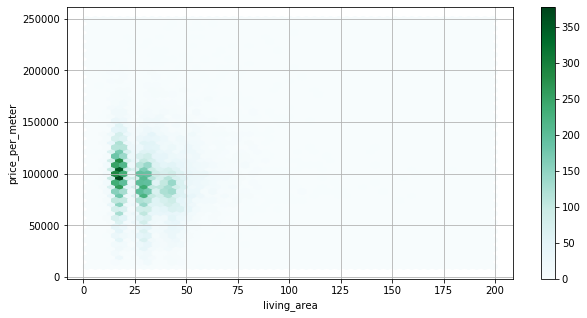

Коэффицент корреляции price_per_meter и living_area :0.08


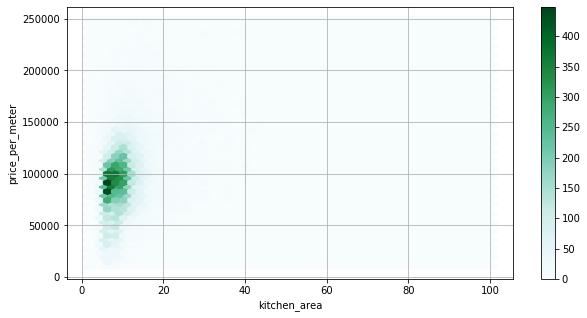

Коэффицент корреляции price_per_meter и kitchen_area :0.34


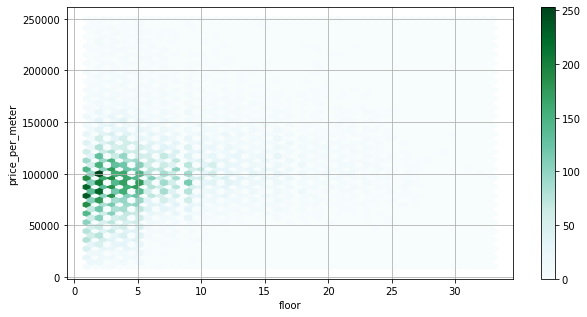

Коэффицент корреляции price_per_meter и floor :0.21


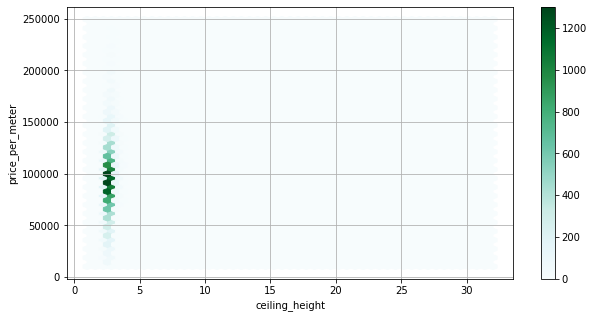

Коэффицент корреляции price_per_meter и ceiling_height :0.06


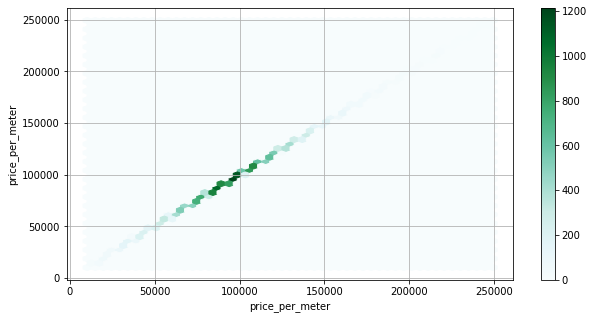

Коэффицент корреляции price_per_meter и price_per_meter :1.0


In [65]:
price_factors = clean_df[['total_area', 'balcony' , 'rooms', 'living_area', 'kitchen_area', 'floor', 'ceiling_height', 'price_per_meter']]
for column in price_factors:
    price_factors.plot(x =  column , y = 'price_per_meter', kind = 'hexbin', gridsize = 50, figsize = (10,5), sharex = False, grid= True)
    corelation = price_factors['price_per_meter'].corr(price_factors[column]).round(2)
    plt.show()
    print('Коэффицент корреляции price_per_meter и {} :{}'.format(column, corelation))

Мы видим, что указанные факторы не имеют сильное влияние на цену за кв м.
Сейчас изучу отношение площади и количества комнат к общей цене.

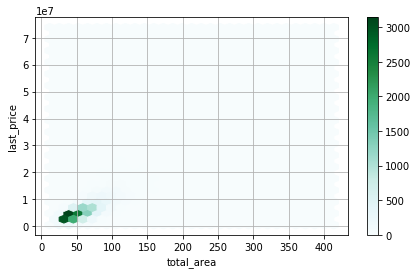

Коэффицент корреляции last_price и total_area :0.83


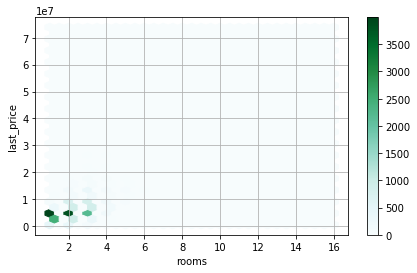

Коэффицент корреляции last_price и rooms :0.55


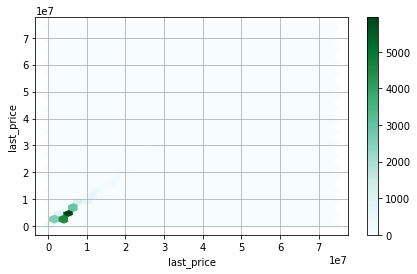

Коэффицент корреляции last_price и last_price :1.0


In [66]:
price_factors2 = clean_df[['total_area' , 'rooms', 'last_price']]
for column in price_factors2:
    price_factors2.plot(x =  column , y = 'last_price', kind = 'hexbin', gridsize = 30, figsize = (7,4), sharex = False, grid= True)
    corelation = price_factors2['last_price'].corr(price_factors2[column]).round(2)
    plt.show()
    print('Коэффицент корреляции last_price и {} :{}'.format(column, corelation))

Здесь мы видим, что итогова цена сильно зависит от общей площади (что логично, так как чем больше, тем дороже)
И видна зависимость от количества комнат. Тоже важное замечание, так как по площади однокомнатная может быть равна или больше
двухкомнатно, например, но семье комфортнее жить в двух раздельных комнатах. Поэтому этот фактор влияет на итоговую цену

Посмотрим зависимость цены от этажа

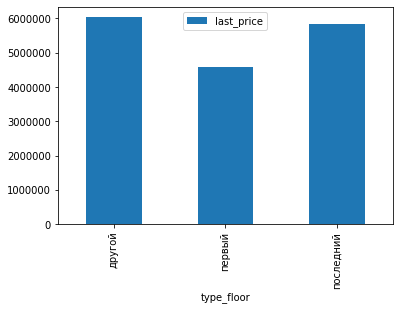

In [67]:
clean_df.groupby('type_floor')['last_price'].mean().plot(kind = 'bar', legend = 'reverse')

Взяв за основу среднее значение по цене квартир на каждом из типов этажей, получили вывод, что квартиры на первом этаже самые
дешевые. Дороже идут на последнем этаже. Все остальные этажи в приоритете
Вероятно, это связано с тем, что жить на первом этаже не комфортно (вид из окна, шум, грязь). 
Либо это загородный одноэтажный дом, что само по себе делает его цену заметно меньше.
Последний этаж тоже не самый привлекательный, особенно в высоких домах.

Рассмотрю зависимость цены от удаленности от центра. За основу также возьму среднюю цену по удаленности

-0.32469119610099056

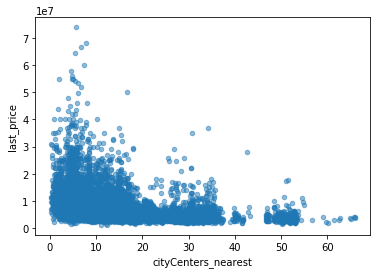

In [68]:
clean_df.plot(kind='scatter', y='last_price', x='cityCenters_nearest', alpha = 0.5)
clean_df['cityCenters_nearest'].corr(clean_df['last_price'])

Налицо очевидная, хоть и не сильная, зависимость стоимости квартиры от близости к центру. Этот факт не удивителен.
Обычная такая закономерность наблюдается во всех городах.
Однако здесь цена не возрастает очень сильно (как, например, в Москве)

Рассмотрим зависимость от дня, месяца и года размещения объявления

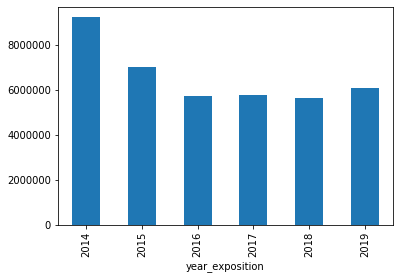

In [69]:
clean_df.groupby('year_exposition')['last_price'].mean().plot(kind = 'bar')

Очевидный вывод, что после кризиса 2014 года цена спикировала вниз. Однако с 2019 года намечается рост
P.S. исключительно предположение (если возможно получить ответ - буду рад): в 2020 году опять же из-за кризиса случилось 
падение цен? Тогда можно было бы точно вывести закономерность, что цена недвижимости сильно зависит от года (от произошедшего)

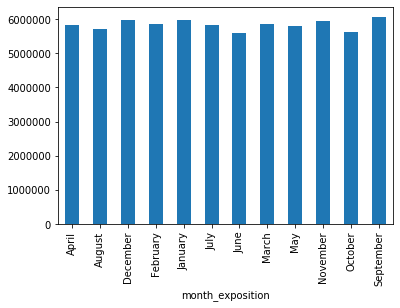

In [70]:
clean_df.groupby('month_exposition')['last_price'].mean().plot(kind = 'bar')

Месяц продажи не сильно влияет

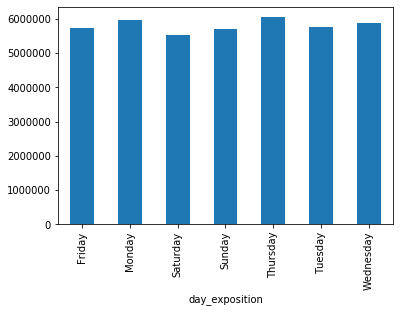

In [71]:
clean_df.groupby('day_exposition')['last_price'].mean().plot(kind = 'bar')

День продажи, очевидно, тоже не влияет. Но это и не удивительно
Как мне кажется, день продажи может повлиять только в экстренном случае (резкое изменение курса валюты)

Отвечая на главный вопрос "Какие факторы больше всего влияют на стоимость" - этаж, удаленность от центра и количество комнат.

Переходим к изучению информации о населенных пунктах
Чтобы ответить на этот вопрос (о 10 населённых пунктах) можно построить сводную таблицу методом pivot_table
К таблице применим функции count и mean
Отсортируем по убыванию

In [72]:
locality_pivot = df.pivot_table(index = 'locality_name', values = 'price_per_meter', aggfunc=['count', 'mean'])
locality_pivot.columns = ['count', 'mean']
locality_pivot.sort_values('count', ascending = False).head(10)

,count,mean
locality_name,,
Санкт-Петербург,15651,114868.877484
поселок Мурино,552,85629.567754
поселок Шушары,439,78551.343964
Всеволожск,398,68654.475628
Пушкин,369,103125.818157
Колпино,338,75424.581953
поселок Парголово,327,90175.915291
Гатчина,307,68746.147231
деревня Кудрово,299,92473.546488


Больше всего объявлений в Санкт-Петербурге. 
По стоимости жилья за кв метр Санкт-Петербург тоже лидер, но не сильно. Следом идет Пушкин, затем деревня Кудрово.

In [73]:
spb_df = clean_df[clean_df['locality_name'] == 'Санкт-Петербург']
spb_df['centers_round'] = clean_df['cityCenters_nearest'].round()
spb_df.isnull().sum()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


total_images               0
last_price                 0
total_area                 0
first_day_exposition       0
rooms                      0
ceiling_height             0
floors_total               0
living_area                0
floor                      0
is_apartment               0
studio                     0
open_plan                  0
kitchen_area             385
balcony                    0
locality_name              0
airports_nearest          57
cityCenters_nearest       37
parks_around3000           0
parks_nearest           7667
ponds_around3000           0
ponds_nearest           7127
days_exposition            0
price_per_meter            0
day_exposition             0
month_exposition           0
year_exposition            0
type_floor                 0
area_ratio                 0
kitchen_area_ratio       385
centers_round             37
dtype: int64

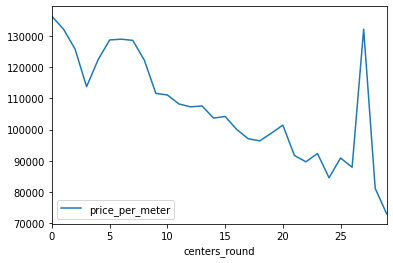

In [74]:
spb_center = spb_df.pivot_table(index = 'centers_round', values = 'price_per_meter')
spb_center.plot()

Согласно графика допустим, что центр в пределах 8 километров, далее резкий упадок и планомерное снижение
резкий скачок цены в районе 27 км можетговорить о том, что там расположен условный элитный район (новостройки, коттеджи)

Теперь проанализирую данные о квартирах в центре Санкт-Петербурга

In [75]:
spb_center_df = spb_df[spb_df['centers_round'] <=  8]
spb_periphery = spb_df[spb_df['centers_round'] > 8]

Создал 2 новые database исключительно с центром города
Посмотрим данные по параметрам у двух баз данных методом describe

In [76]:
spb_center_df[['total_area', 'last_price', 'rooms', 'ceiling_height']].describe()

,total_area,last_price,rooms,ceiling_height
count,3516.000000,3.516000e+03,3516.000000,3516.000000
mean,83.868129,1.049177e+07,2.723265,2.977908
std,44.064971,6.995562e+06,1.338535,0.874911
min,12.000000,1.600000e+06,1.000000,2.000000
25%,53.682500,6.278500e+06,2.000000,2.771499
50%,73.900000,8.500000e+06,3.000000,2.800000
75%,100.000000,1.230000e+07,3.000000,3.100000
max,413.500000,7.390000e+07,16.000000,32.000000


In [77]:
spb_periphery[['total_area', 'last_price', 'rooms', 'ceiling_height']].describe()

,total_area,last_price,rooms,ceiling_height
count,10614.000000,1.061400e+04,10614.000000,10614.000000
mean,55.497149,5.808771e+06,1.979178,2.713655
std,24.263399,3.162291e+06,0.929352,0.651647
min,14.000000,1.190000e+06,1.000000,1.000000
25%,40.000000,3.990000e+06,1.000000,2.560000
50%,50.000000,4.900000e+06,2.000000,2.750000
75%,64.900000,6.500000e+06,3.000000,2.771499
max,398.000000,4.996890e+07,10.000000,27.500000


Проанализируем каждый параметр

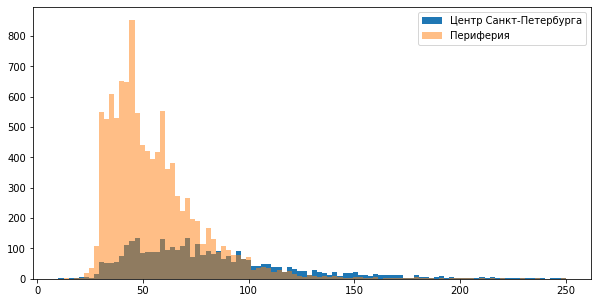

In [78]:
plt.figure(figsize = (10,5))
plt.hist(spb_center_df['total_area'], range=(10,250), bins = 100, alpha = 1, label = 'Центр Санкт-Петербурга')
plt.hist(spb_periphery['total_area'], range=(10,250), alpha = 0.5, bins = 100, label = 'Периферия')
plt.legend(prop={'size':10})

Как мы видим, на периферии гораздо больше квартир с меньшей площадью
А вот в центре много квартир с площадью более 100 кв м.
Вероятно, это связано с тем, что в центре гораздо больше старых зданий с большой площадью

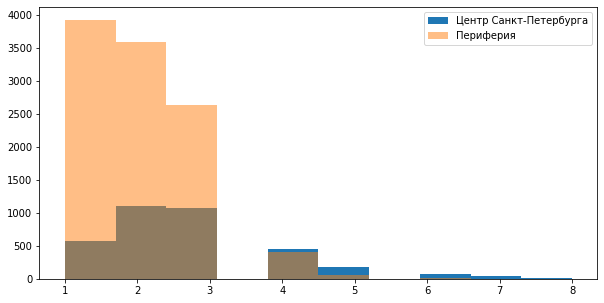

In [79]:
plt.figure(figsize = (10,5))
plt.hist(spb_center_df['rooms'], range=(1,8), bins = 10, alpha = 1, label = 'Центр Санкт-Петербурга')
plt.hist(spb_periphery['rooms'], range=(1,8), alpha = 0.5, bins = 10, label = 'Периферия')
plt.legend(prop={'size':10})

С числом комнат ситуация, как и с площадью, что подтверждает гипотезу о том, что в центре больше старых зданий

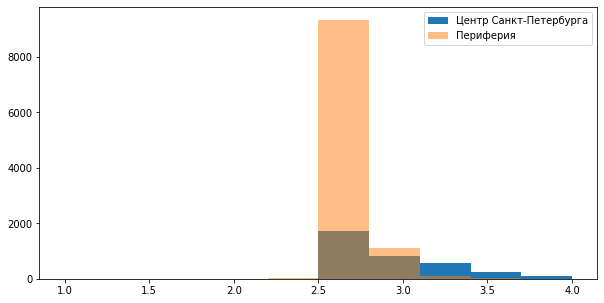

In [80]:
plt.figure(figsize = (10,5))
plt.hist(spb_center_df['ceiling_height'], range=(1,4), bins = 10, alpha = 1, label = 'Центр Санкт-Петербурга')
plt.hist(spb_periphery['ceiling_height'], range=(1,4), alpha = 0.5, bins = 10, label = 'Периферия')
plt.legend(prop={'size':10})

И высота потолков дает нам схожий ответ. В более старых зданиях были большие потолки.
А в зданиях посовременнее, которые строят на новой територии вне цетра, и потолки ниже

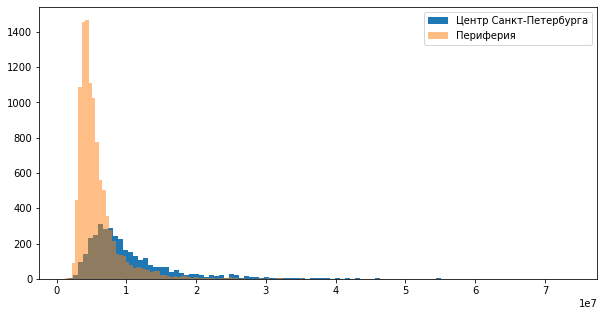

In [81]:
plt.figure(figsize = (10,5))
plt.hist(spb_center_df['last_price'], bins = 100, alpha = 1, label = 'Центр Санкт-Петербурга')
plt.hist(spb_periphery['last_price'], alpha = 0.5, bins = 100, label = 'Периферия')
plt.legend(prop={'size':10})

Цена, как и ожидалась, в центре имеет большой разброс и порой очень высокая
А вот на периферии цена примерно одинаковая, но гораздо меньше, чем в центре

Сейчас изучим и выделим факторы, которые могут влиять на стоимость квартиры в центре
Для этого к каждому фактору построим график и выведем коэффициент корреляции

In [82]:
print('Коэффициент корреляции между ценой и количеством комнат:')
spb_center_df['last_price'].corr(spb_center_df['rooms'])

Коэффициент корреляции между ценой и количеством комнат:


0.554472623819455

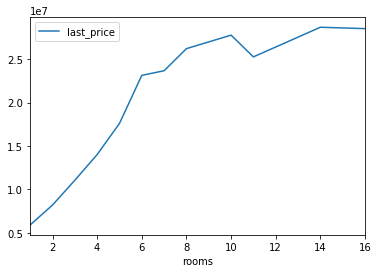

In [83]:
spb_center_rooms = spb_center_df.pivot_table(index = 'rooms', values = 'last_price')
spb_center_rooms.plot()

Очевидна зависимость цены от количества комнат. Но такая зависимость есть во всех обявлениях

In [84]:
print('Коэффициент корреляции между ценой и количеством этажей:')
spb_center_df['last_price'].corr(spb_center_df['floor'])

Коэффициент корреляции между ценой и количеством этажей:


0.1534286775846459

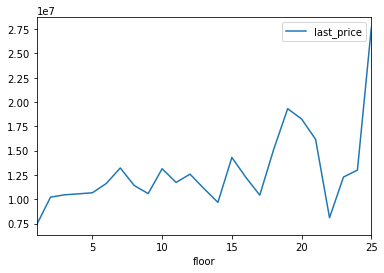

In [85]:
spb_center_floor = spb_center_df.pivot_table(index = 'floor', values = 'last_price')
spb_center_floor.plot()

Цена в центре не имеет сильной зависимости от этажа, однако присутсвуют некоторые скачки:
резкое падение в районе 9, 14, 17, 22 этажа может говорить о том, что эти этажи последние (стандартный набор для последних этажей)
а вот резкий рост в районе 25 этажа говорит о том, что это, вероятно, новый дом, элитная постройка в центре, с хорошими
дорогими квартирами (пентхаусами) на последних этажах

In [86]:
print('Коэффициент корреляции между стоимостью квартиры и удаленностью от центра')
spb_center_df['last_price'].corr(spb_center_df['centers_round'])

Коэффициент корреляции между стоимостью квартиры и удаленностью от центра


-0.09335220708752023

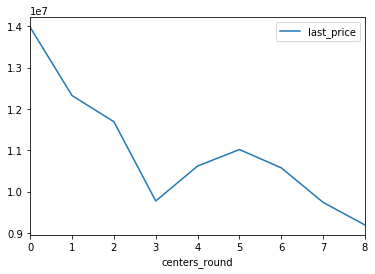

In [87]:
spb_center_nearest = spb_center_df.pivot_table(index = 'centers_round', values = 'last_price')
spb_center_nearest.plot()

На графике видна зависимость удаленности от центра к цене (что актуально для всех городов)

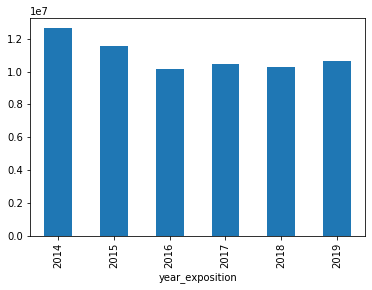

In [88]:
spb_center_df.groupby('year_exposition')['last_price'].mean().plot(kind = 'bar')
plt.show()

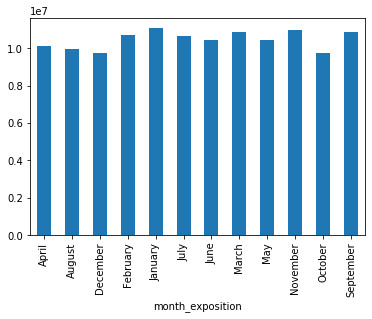

In [89]:
spb_center_df.groupby('month_exposition')['last_price'].mean().plot(kind = 'bar')
plt.show()

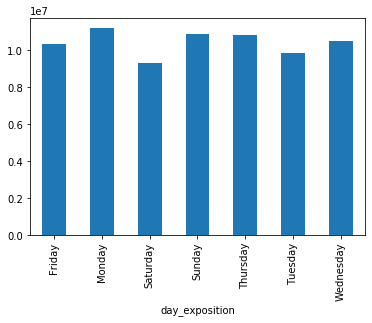

In [90]:
spb_center_df.groupby('day_exposition')['last_price'].mean().plot(kind = 'bar')
plt.show()

Ситуация с годом/месяцем/днём размещения объявления идентична с общей по всем объявлениям.
Присутсвует зависимость от года, остальные факторы не критичны

Ситуация по центру схожа с ситуацией по всем районам. Особенно в части зависимости цены от многих факторов. 
Однако схожа только зависимость, так как сама структура объявления зачастую разная (цена объявлений, тип помещений).

### Шаг 5. Общий вывод

Мною был проведен анализ объявлений Яндекс.Недвижимость. Была произведена работа с пропусками, выбивающимися значениями, в результате чего размер данных уменьшился, но не потерял основные показатели для анализа. 
Мною были проверены различные зависимости, признаки и факторы, влияющие на объявления. На основе моего анализа я смог построить несколько гипотез:

Медианное время продажи квартир - 83 дня. Довольно-таки неплохой срок, учитывая события, котоыре происходили в последние годы и тот факт, что недвижимость - совсем недешевый продукт.
Больше всего на цену влияют площадь, количество комнат, удаленность от центра. Эти факторы наиболее популярны при выборе квартир, поэтому неудивительно, что они оказывают такое влияние на цену.
Наибольшее количество объявлений было в Санкт-Петербурге.
В ближайших районах к городу цена не сильно ниже, чем могло казаться изначально.
В центре города Санкт-Петербург присутсвует элитное жилье, которое стоит заметно выше, чем все остальные.